In [1]:
import torch
from src.utils import EEGIMUDataset, EEGETDataset
from src.lstm_train.models import LSTMRegressor
from src.utils.utils import plot_reconstruction, reconstruct_signal
from pathlib import Path
import json


In [2]:
modelname = "run_20250620_0951"
weights_path = f"../../saved_models/weights/{modelname}.pt"
config_path = f"../../saved_models/configs/{modelname}.json"

with open(config_path, "r") as f:
    config = json.load(f)


In [3]:
# Define Dataset
csv_folder = "../../data/EEG_ET/"
csv_path = sorted(Path(csv_folder).glob("*.csv"))[config["dataset_id"]]
ds = EEGETDataset(csv_path, window=config["window"], stride=config["stride"], bandpass = (1,30))

# TRAIN/TEST/VAL SPLIT
train_loader, val_loader, test_loader = ds.train_test_val_split(config["batch_size"])

# LOAD MODEL
net = LSTMRegressor(in_dim=ds.inp_dim, config=config, out_dim=ds.out_dim)
net.load_state_dict(torch.load(weights_path, map_location="cpu"))
net.eval()

# TESTING
test_loss = 0.0
with torch.no_grad():
    for x_test, y_test in test_loader:
        preds = net(x_test)
        loss = net.crit(preds, y_test)
        test_loss += loss.item() * x_test.size(0)
test_loss /= len(test_loader.dataset)
print(f"Test loss: {test_loss:.3f}")

Test loss: 0.760


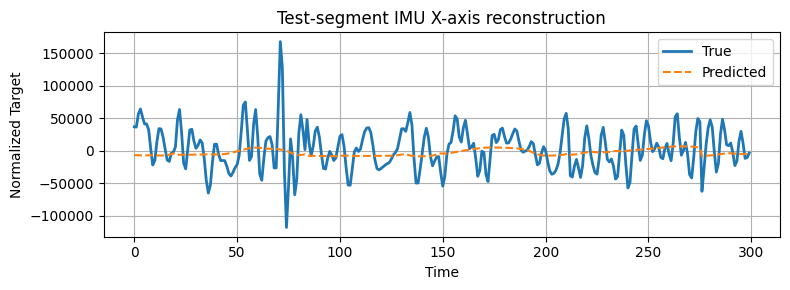

In [4]:
full_pred, full_true = reconstruct_signal(
        net=net, loader=test_loader, base_ds=ds
    )

# Plot an entire Target channel (e.g. x-axis)
fig = plot_reconstruction(
    true=full_true,
    pred=full_pred,
    channel=0,
    timesteps=(300, 600),
    title="Test-segment IMU X-axis reconstruction",
)
